# Poisson Autoencoder Inverting Network (PAIN)
Uses the Tensoflow machine learning library to build and train the Poisson autoencoder inverting network (PAIN) to reconstruct compressed ***MNIST*** images with Poisson noise.

**Author:** Fabian Santiago  
**Update:** August 21, 2024

**Implementation:** PAIN architecture presented in:
**[IEEE publication](https://ieeexplore.ieee.org/abstract/document/8682767)**

## Import Modules and Libraries

In [1]:
# Import necessary modules and libraries 
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from skimage.util.shape import view_as_windows

2024-08-22 09:43:00.752436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set Values: Seed, Compression, and Output Dimension

In [2]:
# Set the seed for TensorFlow and Keras
tf.random.set_seed(101)

# Dimension of the compressed/noisy images (width=height)  
# cmp_dim = 4:(for 4x4), 7:(7x7), 14:(14x14), or 28:(28x284)
cmp_dim = 14

# Dimension of output, original are 28 x 28
out_dim  = 28 

## Helper Function Definitions

In [3]:
# Define sliding window compression
def median_downsampling(in_image, cmp_dim):
    if cmp_dim < 15:
        # Compression dimension to window size
        window_size = 28//cmp_dim
        # Create sliding windows
        windows = view_as_windows(in_image, (window_size, window_size), step=window_size)
        # Calculate the median over each window
        return np.median(windows, axis=(2, 3))
    else:
        return in_image

# Define compression of entries in an array
def down_sample_list(in_array,cmp_dim):
    out_array = np.empty((len(in_array), cmp_dim, cmp_dim))
    
    # Iterate over array
    for idx, image in enumerate(in_array):
        out_array[idx] = median_downsampling(image,cmp_dim)
        
    # Return array containing compressed entries 
    return out_array 

# Split dataset into two
def split_dataset_rnd(in_images):

    # Total number of images
    num_images = in_images.shape[0]
    
    # Random permutation of indices
    shuffled_indices = np.random.permutation(num_images)
    
    # Calculate the split index
    split_index = num_images // 2
    
    # Split the shuffled indices
    idx1 = shuffled_indices[:split_index]
    idx2 = shuffled_indices[split_index:]
    
    # Use the indices to create two random datasets
    dat1 = in_images[idx1]
    dat2 = in_images[idx2]
    
    return dat1, dat2

# Create compressed noisy data
def create_training_test_data(clean_train, clean_test, cmp_dim, out_dim):
    
    # Step 0: Create Training and Validation Sets
    clean_test, clean_valid = split_dataset_rnd(clean_test)
    
    # Step 1: Compress images using median in sliding window
    cmp_train = down_sample_list(clean_train, cmp_dim)
    cmp_test  = down_sample_list(clean_test, cmp_dim)
    cmp_valid = down_sample_list(clean_valid, cmp_dim)

    # Step 2: Add Poisson noise to compressed images
    noisy_train_ = np.random.poisson(lam=cmp_train)
    noisy_test_  = np.random.poisson(lam=cmp_test)
    noisy_valid_ = np.random.poisson(lam=cmp_valid)
    
    noisy_train  = np.clip(noisy_train_,0,255)
    noisy_test   = np.clip(noisy_test_,0,255)
    noisy_valid  = np.clip(noisy_valid_,0,255)
    
    # Step 3: Reshape Input Arrays and scale from [0, 255] to [0,1]
    noisy_train = np.array([matrix.reshape(cmp_dim**2,) for matrix in noisy_train/255])
    noisy_test  = np.array([matrix.reshape(cmp_dim**2,) for matrix in noisy_test/255])
    noisy_valid = np.array([matrix.reshape(cmp_dim**2,) for matrix in noisy_valid/255])
    
    # Step 4: Reshape Expected Ouput Arraus and scale from [0, 255] to [0,1]
    clean_train = np.array([matrix.reshape(out_dim**2,) for matrix in clean_train/255])
    clean_test  = np.array([matrix.reshape(out_dim**2,) for matrix in clean_test/255])
    clean_valid = np.array([matrix.reshape(out_dim**2,) for matrix in clean_valid/255])
    
    # Step 5: Return training data
    return [clean_train, clean_test, clean_valid, noisy_train, noisy_test, noisy_valid]

# PAIN architecture builder function
def build_PAIN(in_dim, out_dim, enc_dim = 256):
    # Input layer
    inputs = tf.keras.Input(shape=(in_dim**2,))

    # First Decoder
    Dec1 = tf.keras.layers.Dense(out_dim**2, activation='sigmoid')(inputs)

    # Encoder
    Enc2_hidden = tf.keras.layers.Dense(enc_dim, activation='sigmoid')(Dec1)
    Enc2 = tf.keras.layers.Dense(in_dim**2, activation='sigmoid')(Enc2_hidden)

    # Second Decoder
    Dec2_hidden = tf.keras.layers.Dense(enc_dim, activation='sigmoid')(Enc2)
    outputs = tf.keras.layers.Dense(out_dim**2, activation='sigmoid')(Dec2_hidden)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

## Load/Create Training Data
Load traning data or load MNIST data and create training data if it has not already been created

In [4]:
directory = 'training_data'

# If the directory does not exist, create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Load the MNIST Dataset
file = f'mnist_training_data_cmp' # Do not modify

# If the training data does not exist, create it
if not os.path.exists(f'{directory}/{file}_{cmp_dim}x{cmp_dim}.h5'):
    # Load MNIST
    (clean_train, _), (clean_test, _) = tf.keras.datasets.mnist.load_data()
    
    # Create compressed/noisy data, test set, and validation set
    train_data = create_training_test_data(clean_train, clean_test, cmp_dim, out_dim)
    
    # MNIST data
    clean_train = train_data[0]
    clean_test  = train_data[1]
    clean_valid = train_data[2]
    
    # Compressed noisy signals
    noisy_train = train_data[3]
    noisy_test  = train_data[4]
    noisy_valid = train_data[5]
    
    # Save with compression
    with h5py.File(f'{directory}/{file}_{cmp_dim}x{cmp_dim}.h5', 'w') as f:
        # Save original images
        f.create_dataset('clean_train', data=clean_train, compression='gzip')
        f.create_dataset('clean_test', data=clean_test, compression='gzip')
        f.create_dataset('clean_valid', data=clean_valid, compression='gzip')
        
        # Save compressed noisy images
        f.create_dataset('noisy_train', data=noisy_train, compression='gzip')
        f.create_dataset('noisy_test', data=noisy_test, compression='gzip')
        f.create_dataset('noisy_valid', data=noisy_valid, compression='gzip')
        
else: # If data exists, load it
    with h5py.File(f'{directory}/{file}_{cmp_dim}x{cmp_dim}.h5', 'r') as dat_file:

        # Load original MNIST images
        clean_train = dat_file['clean_train'][:]
        clean_test  = dat_file['clean_test'][:]
        clean_valid = dat_file['clean_valid'][:]

        # Load compressed noisy images
        noisy_train = dat_file['noisy_train'][:]
        noisy_test  = dat_file['noisy_test'][:]
        noisy_valid = dat_file['noisy_valid'][:]

## Display Training Dataset Examples

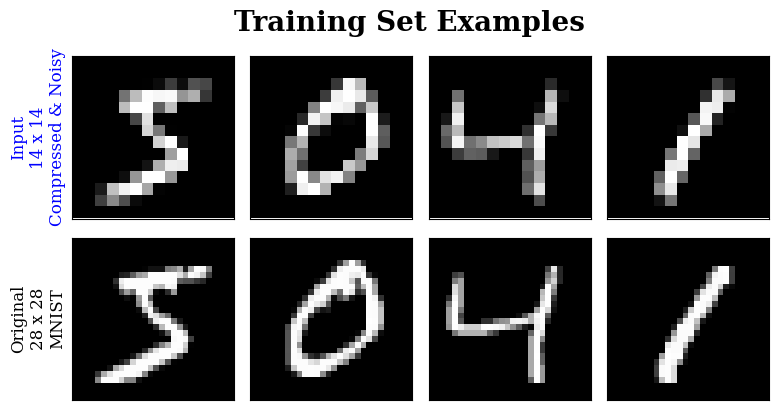

In [37]:
# Display: training set
#######################

# Create a 2 by 4 subplot handle
fig, axes = plt.subplots(2, 4, figsize=(9, 4.5))
axes      = axes.flatten()

# Add title
fig.suptitle('Training Set Examples', fontsize=20, fontweight='bold', fontfamily='serif')

# Shift window through training dataset 
sft_idx = 0

# Plot noisy and decompressed realizations in each subplot
for idx in range(4):
    # Plot noisy
    axes[idx].imshow(noisy_train[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
    
    # Plot original
    axes[idx+4].imshow(clean_train[idx+sft_idx].reshape(out_dim,out_dim),cmap='gray')
    axes[idx+4].set_xticks([]) # Remove xticklabels
    axes[idx+4].set_yticks([]) # Remove yticklabels 
    
# Set ylables 
axes[0].set_ylabel(f'Input\n{cmp_dim} x {cmp_dim}\nCompressed & Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[4].set_ylabel(f'Original\n{out_dim} x {out_dim}\nMNIST',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Display the figure
plt.show()

## Compile & Train Model

In [6]:
# Set threads using 6 CPU cores
tf.config.threading.set_intra_op_parallelism_threads(6)

# Create & Compile the PAIN model
PAIN = build_PAIN(in_dim=cmp_dim, out_dim=out_dim)

# Create an RMSProp optimizer with a specific learning rate
RMSp = tf.keras.optimizers.RMSprop(learning_rate=0.05)

# Compile the model
PAIN.compile(optimizer=RMSp, loss='mean_squared_error')

# Train model and saving fitting history
fit_history = PAIN.fit(noisy_train, clean_train, epochs=120, batch_size=250, validation_data=(noisy_test, clean_test))

Epoch 1/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0726 - val_loss: 0.0678
Epoch 2/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0676 - val_loss: 0.0656
Epoch 3/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0642 - val_loss: 0.0599
Epoch 4/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0598 - val_loss: 0.0589
Epoch 5/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0587 - val_loss: 0.0558
Epoch 6/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0552 - val_loss: 0.0527
Epoch 7/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0525 - val_loss: 0.0499
Epoch 8/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0495 - val_loss: 0.0473
Epoch 9/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0460 - val_loss: 0.0419
Epoch 10/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0412 - val_loss: 0.0376
Epoch 11/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0371 - val_loss: 0.0344
Epoch 12/120
240/240 ━━━━━━━━━

240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 68/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 69/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 70/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 71/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0109 - val_loss: 0.0110
Epoch 72/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 73/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 74/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 75/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 76/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 77/120
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 78/120
240/240 ━━━━━━━━━━━━━

In [7]:
PAIN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 784)            │       154,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 196)            │        50,372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        50,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,315,402 (5.02 MB)

 Trainable params: 657,700 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 657,702 (2.51 MB)

## Apply PAIN to Training Set and Display Example Output

In [12]:
# Save output
imdir = 'method_results'

# If the save directory does not exist, create it
if not os.path.exists(imdir):
    os.makedirs(imdir)

# Save file name
imfile = f'mnist_reconstruct'

In [13]:
pred_train_out = PAIN.predict(noisy_train[0:101])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


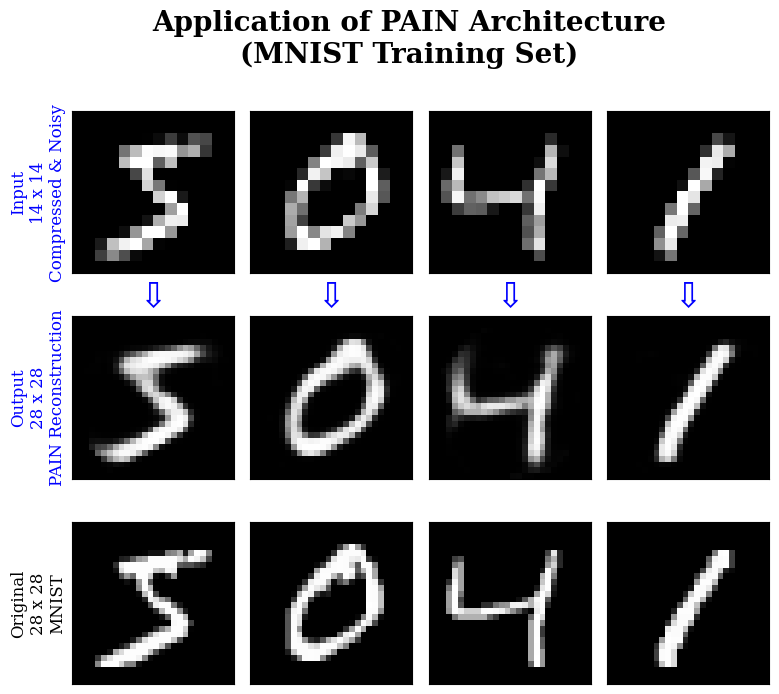

In [36]:
# Create a 3 by 4 subplot handle
fig, axes = plt.subplots(3, 4, figsize=(9, 8))
axes      = axes.flatten()

# Add title
fig.suptitle('Application of PAIN Architecture\n(MNIST Training Set)',fontsize=20,fontweight='bold', fontfamily='serif')

# Shift window through training dataset 
sft_idx = 0

# Plot noisy and decompressed realizations in each subplot
for idx in range(4):
    # Plot noisy
    axes[idx].imshow(noisy_train[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
    axes[idx].set_xlabel('⇩',fontdict={'fontsize': 25, 'fontweight': 'bold', 'fontfamily': 'serif', 'color':'blue'})
    
    # Plot decompressed with PAIN
    axes[idx+4].imshow(pred_train_out[idx+sft_idx].reshape(out_dim,out_dim),cmap='gray')
    axes[idx+4].set_xticks([]) # Remove xticklabels
    axes[idx+4].set_yticks([]) # Remove yticklabels
    
    # Plot original
    axes[idx+8].imshow(clean_train[idx+sft_idx].reshape(out_dim,out_dim),cmap='gray')
    axes[idx+8].set_xticks([]) # Remove xticklabels
    axes[idx+8].set_yticks([]) # Remove yticklabels
    
# Set ylables 
axes[0].set_ylabel(f'Input\n{cmp_dim} x {cmp_dim}\nCompressed & Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[4].set_ylabel(f'Output\n{out_dim} x {out_dim}\nPAIN Reconstruction',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[8].set_ylabel(f'Original\n{out_dim} x {out_dim}\nMNIST',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.00)

# Save results 
plt.savefig(f'{imdir}/{imfile}_{cmp_dim}x{cmp_dim}_train_PAIN.png')

# Display the figure
plt.show()

## Apply PAIN to Validation Set and Display Output

In [15]:
# Apply PAIN to all validation data inputs
pred_valid_out = PAIN.predict(noisy_valid[0:101])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


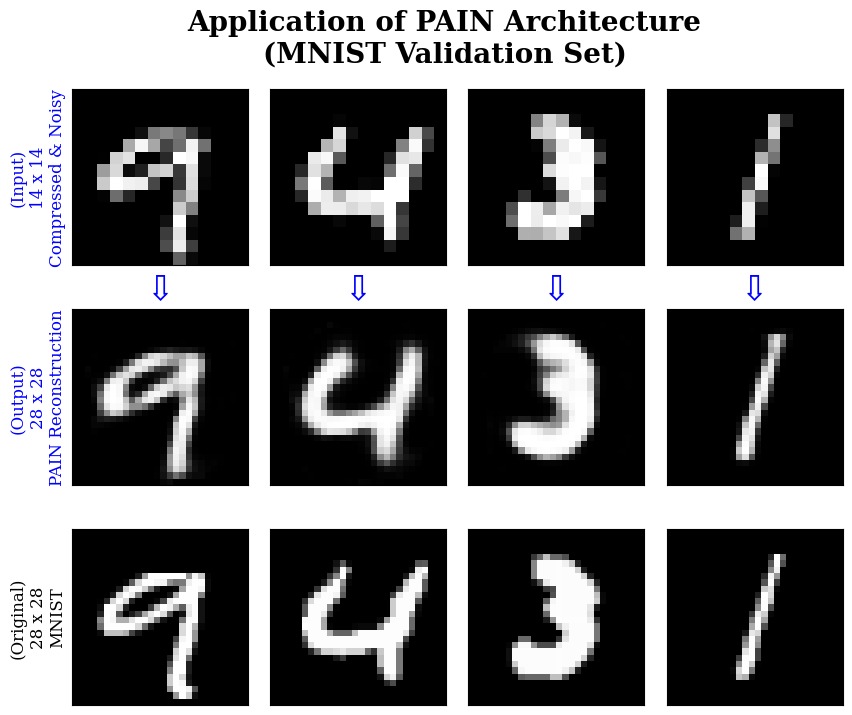

In [34]:
# Create a 3 by 4 subplot handle
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes      = axes.flatten()

# Add title
fig.suptitle('Application of PAIN Architecture\n(MNIST Validation Set)',fontsize=20,fontweight='bold', fontfamily='serif')

# Shift window through validation dataset 
sft_idx = 0

# Plot noisy and decompressed realizations in each subplot
for idx in range(4):
    # Plot noisy
    axes[idx].imshow(noisy_valid[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
    axes[idx].set_xlabel('⇩',fontdict={'fontsize': 25, 'fontweight': 'bold', 'fontfamily': 'serif', 'color':'blue'})
    
    # Plot decompressed with PAIN
    axes[idx+4].imshow(pred_valid_out[idx+sft_idx].reshape(28,28),cmap='gray')
    axes[idx+4].set_xticks([]) # Remove xticklabels
    axes[idx+4].set_yticks([]) # Remove yticklabels
    
    # Plot original
    axes[idx+8].imshow(clean_valid[idx+sft_idx].reshape(28,28),cmap='gray')
    axes[idx+8].set_xticks([]) # Remove xticklabels
    axes[idx+8].set_yticks([]) # Remove yticklabels
    
# Set ylables 
axes[0].set_ylabel(f'(Input)\n{cmp_dim} x {cmp_dim}\nCompressed & Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[4].set_ylabel(f'(Output)\n{out_dim} x {out_dim}\nPAIN Reconstruction',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[8].set_ylabel(f'(Original)\n{out_dim} x {out_dim}\nMNIST',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.25)

# Save results 
plt.savefig(f'{imdir}/{imfile}_{cmp_dim}x{cmp_dim}_valid_PAIN.png')

# Display the figure
plt.show()